# Context
Building a sentiment analysis model using IMDB reviews dataset

# Importings

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

import pathlib, os, shutil, random, string

import tensorflow as tf
from tensorflow import keras
from keras.layers import TextVectorization
from keras.utils import text_dataset_from_directory

# Install tree
!apt-get update
!apt-get install tree

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [908 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:14 http://secu


# Dataset
In this proejct, we're gonna use the dataset from [the Stanford page of Andrew Maas](https:/ /ai.stanford.edu/~amaas/data/sentiment)

In [3]:
# Download and unzip the dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  29.4M      0  0:00:02  0:00:02 --:--:-- 29.4M


# Data directory structure

In [4]:
!tree -d aclImdb

aclImdb
├── test
│   ├── neg
│   └── pos
└── train
    ├── neg
    ├── pos
    └── unsup

7 directories


We have two directories for training and testing datasets, each one has two classes, negative and positive. There's also train/unsup, we don't want that. Let's delete it.

In [5]:
!rm -r aclImdb/train/unsup

Let's take a look at the content of a text file in the train dataset

In [6]:
!cat aclImdb/train/pos/0_9.txt

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

We will now take 20% of the train set to create a validation set in a new directory aclImdb/val

In [7]:
base_dir = pathlib.Path("aclImdb")
train_dir = base_dir / "train"
val_dir = base_dir / "val"

os.makedirs(val_dir)

for cat in ("neg","pos"):
  os.makedirs(val_dir / cat)
  fnames = os.listdir(train_dir / cat)
  random.Random(42).shuffle(fnames)
  val_size = int(len(fnames) * 0.2)
  val_files = fnames[-val_size:]
  for f in val_files:
     shutil.move(train_dir/cat/f,val_dir/cat)

In [8]:
print(f"Train neg: {len(os.listdir(train_dir/'neg'))}, Train pos: {len(os.listdir(train_dir/'pos'))}")
print(f"Val neg: {len(os.listdir(val_dir/'neg'))}, Val pos: {len(os.listdir(val_dir/'pos'))}")


Train neg: 10000, Train pos: 10000
Val neg: 2500, Val pos: 2500


In [9]:
# Load the data in a Dataset objects
batch_size = 32
train_ds = text_dataset_from_directory(base_dir/"train",batch_size=batch_size)
val_ds = text_dataset_from_directory(base_dir/"val",batch_size=batch_size)
test_ds = text_dataset_from_directory(base_dir/"test",batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [10]:
for inputs, targets in train_ds:
  print(f"Input shape: {inputs.shape}")
  print(f"Input Dtype: {inputs.dtype}")
  print(f"Input[0]: {inputs[0]}")
  print()
  print(f"Target shape: {targets.shape}")
  print(f"Target Dtype: {targets.dtype}")
  print(f"Target[0]: {targets[0]}")
  break

Input shape: (32,)
Input Dtype: <dtype: 'string'>
Input[0]: b"Class Reunion is a very underated comedy gem. It's 1982 and the 1972 class of Lizzie Borden High return for there 10 year reunion, among them are the usual stereotypes, the hunk, babe, the fat guy & nerd etc, but the former students are in for a bumpy night, one of their classmates is Walter Baloer, the class wimp who was subject to a comedy prank by the rest of the class on graduation night and since then has been in a mental home, Walter escapes and now plans to avenge his humiliation,,,,<br /><br />Despite the dark premise, this is really just an excuse for lots of very funny gags & set pieces. To say too much more would spoil the film but if you enjoyed the Naked Gun & Airplane movies you'll love this, & what other film offers a music cameo by Chuck Berry?. A great comedy which deserves a wider audience."

Target shape: (32,)
Target Dtype: <dtype: 'int32'>
Target[0]: 1


# Baseline Model and Performance Measure
Since the dataset is a balanced two-class classification, our naive baseline would be 50%, and the performance measure would be the accuracy

# Models Arcitectures


1.  Binary Unigram Dense Model
  *   TextVectorization => output_mode(multi_hot) + ngrams(1)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Dense(16,relu) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
2.   Binary Bigram Dense Model
  *   TextVectorization => output_mode(multi_hot) + ngrams(2)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Dense(16,relu) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
3.   Binary TF-IDF Dense Model
  *   TextVectorization => output_mode(tf_idf) + ngrams(2)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Dense(16,relu) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
4.   One-Hot Bidirectional LSTM Model
  *   TextVectorization => output_mode(int)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => one_hot() + Bidirectioanl_LSTM(32) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
5.   Embedding Bidirectional LSTM Model
  *   TextVectorization => output_mode(int)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Embedding(256) + Bidirectioanl_LSTM(32) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
6.   Pre-trained Embedding Bidirectional LSTM Model
  *   TextVectorization => output_mode(int)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Embedding(100) + Bidirectioanl_LSTM(32) + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
7. TransformerEncoder Model
  *   TextVectorization => output_mode(int)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => Embedding(256) + TransformerEncoder(32) + GlobalMaxPooling1D() + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)
8. TransformerEncoder with PositionalEmbedding Model
  *   TextVectorization => output_mode(int)
  *   Input_layer => shape = (20000,)
  *   Hidden_layers => PositionalEmbedding(256) + TransformerEncoder(32) + GlobalMaxPooling1D() + Dropout(0.5)
  *   Output_layer => Dense(1, sigmoid)

## 1. Binary Unigram Dense Model

In [11]:
train_ds_x = train_ds.map(lambda x,y: x)
max_tokens = 20_000

text_vectorization = TextVectorization(max_tokens=max_tokens,output_mode="multi_hot")
text_vectorization.adapt(train_ds_x)

train_ds_multi_hot = train_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
val_ds_multi_hot = val_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
test_ds_multi_hot = test_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
inputs = keras.Input(shape=(max_tokens,))
x = keras.layers.Dense(16,activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("binary_unigram_dense.keras",save_best_only=True)]

history = model.fit(train_ds_multi_hot.cache(), epochs=10, validation_data=val_ds_multi_hot.cache(), callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 10s 9ms/step - loss: 0.4257 - accuracy: 0.8189 - val_loss: 0.3007 - val_accuracy: 0.8794
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2858 - accuracy: 0.8978 - val_loss: 0.2931 - val_accuracy: 0.8890
Epoch 3/10
625/625 [==============================] - 3s 6ms/step - loss: 0.2505 - accuracy: 0.9108 - val_loss: 0.2979 - val_accuracy: 0.8904
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2282 - accuracy: 0.9209 - val_loss: 0.3176 - val_accuracy: 0.8894
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2251 - accuracy: 0.9254 - val_loss: 0.3270 - val_accuracy: 0.8900
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2172 - accuracy: 0.9287 - val_loss: 0.3369 - val_accuracy: 0.8836
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2152 - accuracy: 0.9294 - val_loss: 0.3494 - val_accuracy: 0.8816
Epoch

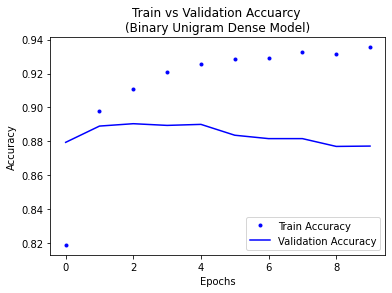

In [13]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(Binary Unigram Dense Model)")
plt.legend()
plt.show()

In [14]:
model = keras.models.load_model("binary_unigram_dense.keras")
loss, acc = model.evaluate(test_ds_multi_hot)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.2917 - accuracy: 0.8860
Accuracy: 0.886


## 2. Binary Bigram Dense Model


In [15]:
text_vectorization = TextVectorization(max_tokens=max_tokens, ngrams=2, output_mode="multi_hot")

text_vectorization.adapt(train_ds_x)
train_ds_2gram = train_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
val_ds_2gram = val_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
test_ds_2gram = test_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)

In [16]:
inputs = keras.Input(shape=max_tokens)
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics="accuracy")

callbacks = [keras.callbacks.ModelCheckpoint("binary_bigram_dense.keras", save_best_only=True)]

history = model.fit(train_ds_2gram.cache(), epochs=10, validation_data=val_ds_2gram, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.3771 - accuracy: 0.8420 - val_loss: 0.2711 - val_accuracy: 0.8928
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2391 - accuracy: 0.9176 - val_loss: 0.2772 - val_accuracy: 0.8928
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1968 - accuracy: 0.9378 - val_loss: 0.2948 - val_accuracy: 0.8976
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1858 - accuracy: 0.9444 - val_loss: 0.3096 - val_accuracy: 0.8952
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1684 - accuracy: 0.9499 - val_loss: 0.3242 - val_accuracy: 0.8918
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.1612 - accuracy: 0.9545 - val_loss: 0.3508 - val_accuracy: 0.8884
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1466 - accuracy: 0.9588 - val_loss: 0.3704 - val_accuracy: 0.8900
Epoch

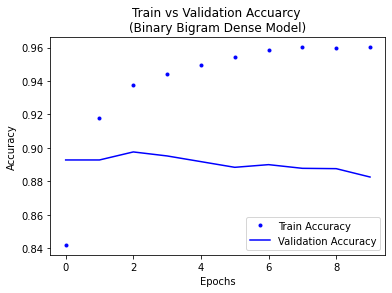

In [17]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(Binary Bigram Dense Model)")
plt.legend()
plt.show()

In [18]:
model = keras.models.load_model("binary_bigram_dense.keras")
loss, acc = model.evaluate(test_ds_2gram)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 6s 7ms/step - loss: 0.2689 - accuracy: 0.8934
Accuracy: 0.893


## 3. Binary TF-IDF Dense Model

In [19]:
text_vectorization = TextVectorization(ngrams=2, max_tokens=max_tokens, output_mode="tf_idf")

text_vectorization.adapt(train_ds_x)
train_ds_bigram_tfidf = train_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=True)
val_ds_bigram_tfidf = val_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=True)
test_ds_bigram_tfidf = test_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=True)


In [20]:
inputs = keras.Input(shape=max_tokens)
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics="accuracy")

callbacks = [keras.callbacks.ModelCheckpoint("binary_tfidf_dense.keras", save_best_only=True)]

history = model.fit(train_ds_bigram_tfidf.cache(), epochs=10, validation_data=val_ds_bigram_tfidf, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.4805 - accuracy: 0.7930 - val_loss: 0.3240 - val_accuracy: 0.8646
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3134 - accuracy: 0.8755 - val_loss: 0.3148 - val_accuracy: 0.8748
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2809 - accuracy: 0.8886 - val_loss: 0.3402 - val_accuracy: 0.8502
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2554 - accuracy: 0.8979 - val_loss: 0.3872 - val_accuracy: 0.8550
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2470 - accuracy: 0.9003 - val_loss: 0.3191 - val_accuracy: 0.8782
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2308 - accuracy: 0.9078 - val_loss: 0.3479 - val_accuracy: 0.8638
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2277 - accuracy: 0.9074 - val_loss: 0.3853 - val_accuracy: 0.8688
Epoch

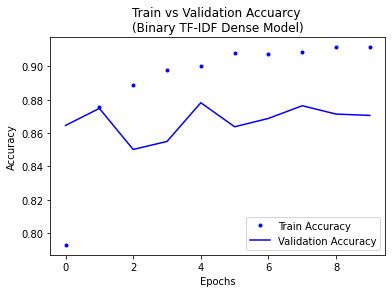

In [21]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(Binary TF-IDF Dense Model)")
plt.legend()
plt.show()

In [22]:
model = keras.models.load_model("binary_tfidf_dense.keras")
loss, acc = model.evaluate(test_ds_bigram_tfidf)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 5s 6ms/step - loss: 0.3141 - accuracy: 0.8765
Accuracy: 0.877


## 4.  One-Hot Bidirectional LSTM Model

In [23]:
max_length = 600
text_vectorization = TextVectorization(max_tokens=max_tokens,output_sequence_length=max_length,output_mode="int")

text_vectorization.adapt(train_ds_x)
train_ds_int = train_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
val_ds_int = val_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)
test_ds_int = test_ds.map(lambda x,y: (text_vectorization(x),y), num_parallel_calls=4)

In [24]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("onehot_bidirectioanl_lstm.keras", save_best_only=True)]

history = model.fit(train_ds_int, epochs=10, validation_data=val_ds_int, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 161s 249ms/step - loss: 0.5614 - accuracy: 0.7099 - val_loss: 0.5254 - val_accuracy: 0.7780
Epoch 2/10
625/625 [==============================] - 161s 258ms/step - loss: 0.3676 - accuracy: 0.8629 - val_loss: 0.3748 - val_accuracy: 0.8680
Epoch 3/10
625/625 [==============================] - 162s 259ms/step - loss: 0.2961 - accuracy: 0.8925 - val_loss: 0.3054 - val_accuracy: 0.8866
Epoch 4/10
625/625 [==============================] - 163s 261ms/step - loss: 0.2542 - accuracy: 0.9111 - val_loss: 0.3101 - val_accuracy: 0.8800
Epoch 5/10
625/625 [==============================] - 164s 262ms/step - loss: 0.2228 - accuracy: 0.9262 - val_loss: 0.3311 - val_accuracy: 0.8772
Epoch 6/10
625/625 [==============================] - 164s 263ms/step - loss: 0.1990 - accuracy: 0.9351 - val_loss: 0.3167 - val_accuracy: 0.8800
Epoch 7/10
625/625 [==============================] - 165s 264ms/step - loss: 0.1746 - accuracy: 0.9435 - val_loss: 0.6134 -

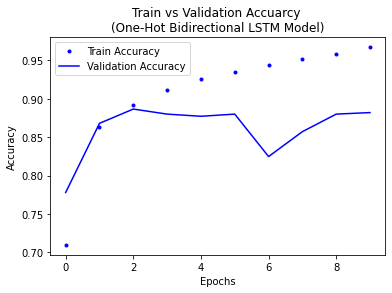

In [25]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(One-Hot Bidirectional LSTM Model)")
plt.legend()
plt.show()

In [26]:
model = keras.models.load_model("onehot_bidirectioanl_lstm.keras")
loss, acc = model.evaluate(test_ds_int)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 95s 121ms/step - loss: 0.3085 - accuracy: 0.8790
Accuracy: 0.879


## 5. Embedding Bidirectional LSTM Model

In [27]:
inputs = keras.Input(shape=(None,),dtype="int64")
embedded = keras.layers.Embedding(input_dim=max_tokens,output_dim=256, mask_zero=True)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("embedding_bidirectional_lstm.keras")]

history = model.fit(train_ds_int, epochs=10, validation_data=val_ds_int, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 97s 142ms/step - loss: 0.4407 - accuracy: 0.7896 - val_loss: 0.3427 - val_accuracy: 0.8550
Epoch 2/10
625/625 [==============================] - 52s 84ms/step - loss: 0.2842 - accuracy: 0.8870 - val_loss: 0.2969 - val_accuracy: 0.8780
Epoch 3/10
625/625 [==============================] - 40s 64ms/step - loss: 0.2187 - accuracy: 0.9170 - val_loss: 0.3028 - val_accuracy: 0.8800
Epoch 4/10
625/625 [==============================] - 34s 55ms/step - loss: 0.1698 - accuracy: 0.9399 - val_loss: 0.3316 - val_accuracy: 0.8776
Epoch 5/10
625/625 [==============================] - 34s 54ms/step - loss: 0.1295 - accuracy: 0.9549 - val_loss: 0.3694 - val_accuracy: 0.8728
Epoch 6/10
625/625 [==============================] - 35s 56ms/step - loss: 0.0975 - accuracy: 0.9668 - val_loss: 0.4379 - val_accuracy: 0.8774
Epoch 7/10
625/625 [==============================] - 32s 51ms/step - loss: 0.0731 - accuracy: 0.9756 - val_loss: 0.4450 - val_accuracy

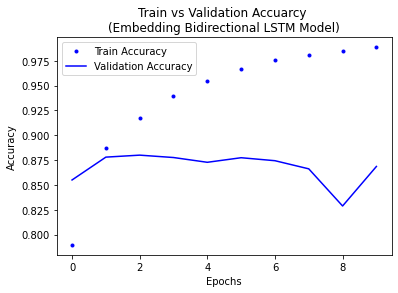

In [28]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(Embedding Bidirectional LSTM Model)")
plt.legend()
plt.show()

In [29]:
model = keras.models.load_model("embedding_bidirectional_lstm.keras")
loss, acc = model.evaluate(test_ds_int)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 17s 18ms/step - loss: 0.6371 - accuracy: 0.8618
Accuracy: 0.862


## 6. Pre-trained Embedding Bidirectional LSTM Model

We're gonna try [Global Vectors](https://nlp.stanford.edu/projects/glove) for Word Representation which was developed by Stanford researchers in 2014

In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-12 18:46:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-12 18:46:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-12 18:46:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [31]:
# Uploading the glove file as a python dictionary
glove_100d = 'glove.6B.100d.txt'

embeddings_index = {}
with open(glove_100d) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs,'f',sep=' ')
    embeddings_index[word] = coefs

len(embeddings_index)

400000

In [32]:
# Craeting the embedding_matrix
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
inputs = keras.Input(shape=(None,),dtype="int64")
embedded = keras.layers.Embedding(max_tokens,embedding_dim,
                                         embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                         trainable=False, mask_zero=True)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint("glove_embedding_bidirectioanl_lstm.keras", save_best_only=True)]

history = model.fit(train_ds_int, epochs=10, validation_data=val_ds_int, callbacks=callbacks)
                                        

Epoch 1/10
625/625 [==============================] - 52s 69ms/step - loss: 0.5793 - accuracy: 0.6867 - val_loss: 0.4661 - val_accuracy: 0.7920
Epoch 2/10
625/625 [==============================] - 36s 57ms/step - loss: 0.4556 - accuracy: 0.7936 - val_loss: 0.4121 - val_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 34s 55ms/step - loss: 0.4043 - accuracy: 0.8223 - val_loss: 0.3665 - val_accuracy: 0.8446
Epoch 4/10
625/625 [==============================] - 31s 49ms/step - loss: 0.3742 - accuracy: 0.8370 - val_loss: 0.3456 - val_accuracy: 0.8564
Epoch 5/10
625/625 [==============================] - 37s 59ms/step - loss: 0.3470 - accuracy: 0.8508 - val_loss: 0.3402 - val_accuracy: 0.8618
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.3247 - accuracy: 0.8638 - val_loss: 0.3491 - val_accuracy: 0.8556
Epoch 7/10
625/625 [==============================] - 34s 55ms/step - loss: 0.3054 - accuracy: 0.8723 - val_loss: 0.3125 - val_accuracy:

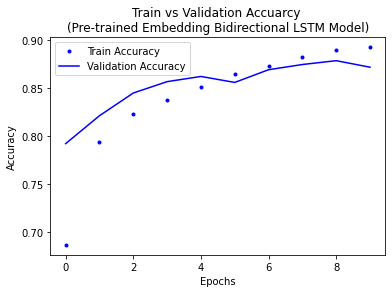

In [34]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(Pre-trained Embedding Bidirectional LSTM Model)")
plt.legend()
plt.show()

In [35]:
model = keras.models.load_model("glove_embedding_bidirectioanl_lstm.keras")
loss, acc = model.evaluate(test_ds_int)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 21s 23ms/step - loss: 0.2910 - accuracy: 0.8761
Accuracy: 0.876


## 7. TransformerEncoder Model

In [47]:
# Create a TransformerEncoder class
class TransformerEncoder(keras.layers.Layer):
    def __init__(self,embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([keras.layers.Dense(dense_dim,activation="relu"),keras.layers.Dense(embed_dim),])
        self.layernorm_1 = keras.layers.LayerNormalization()
        self.layernorm_2 = keras.layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output =self.attention(inputs,inputs,attention_mask=mask)
        proj_input = self.layernorm_1(inputs+attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input+proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

In [48]:
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,),dtype="int64")
x = keras.layers.Embedding(max_tokens, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder.keras", save_best_only=True)]

history = model.fit(train_ds_int, epochs=20, validation_data=val_ds_int, callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 67s 102ms/step - loss: 0.4851 - accuracy: 0.7714 - val_loss: 0.3827 - val_accuracy: 0.8268
Epoch 2/20
625/625 [==============================] - 51s 81ms/step - loss: 0.3394 - accuracy: 0.8550 - val_loss: 0.3638 - val_accuracy: 0.8358
Epoch 3/20
625/625 [==============================] - 49s 78ms/step - loss: 0.3030 - accuracy: 0.8717 - val_loss: 0.3010 - val_accuracy: 0.8684
Epoch 4/20
625/625 [==============================] - 46s 74ms/step - loss: 0.2699 - accuracy: 0.8879 - val_loss: 0.3075 - val_accuracy: 0.8666
Epoch 5/20
625/625 [==============================] - 46s 73ms/step - loss: 0.2384 - accuracy: 0.9050 - val_loss: 0.3009 - val_accuracy: 0.8764
Epoch 6/20
625/625 [==============================] - 45s 72ms/step - loss: 0.2065 - accuracy: 0.9190 - val_loss: 0.3072 - val_accuracy: 0.8806
Epoch 7/20
625/625 [==============================] - 44s 70ms/step - loss: 0.1773 - accuracy: 0.9319 - val_loss: 0.3454 - val_accuracy

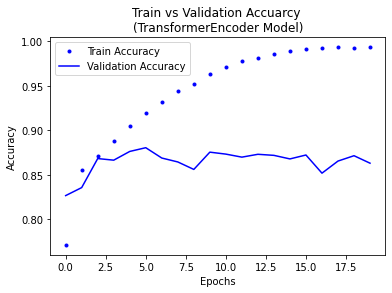

In [49]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(TransformerEncoder Model)")
plt.legend()
plt.show()

In [50]:
model = keras.models.load_model("transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder})
loss, acc = model.evaluate(test_ds_int)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 19s 24ms/step - loss: 0.3058 - accuracy: 0.8730
Accuracy: 0.873


## 8.TransformerEncoder with PositionalEmbedding Model

In [51]:
# Create a PositionalEmbedding Class
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self,sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.tokens_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    def call(self,inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0,limit=length, delta=1)
        embedded_tokens = self.tokens_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs,0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim":self.output_dim,
            "input_dim":self.input_dim,
            "sequence_length":self.sequence_length
        })
        return config

In [52]:
inputs = keras.Input(shape=(None,),dtype="int64")
embedded = PositionalEmbedding(sequence_length=max_length, input_dim=max_tokens, output_dim=embed_dim)(inputs)
x = TransformerEncoder(embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads)(embedded)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs,outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("transformer_encoder_positional_embeddings.keras", save_best_only=True)]

history = model.fit(train_ds_int, epochs=20, validation_data=val_ds_int, callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 73s 113ms/step - loss: 0.5448 - accuracy: 0.7336 - val_loss: 0.3369 - val_accuracy: 0.8496
Epoch 2/20
625/625 [==============================] - 54s 87ms/step - loss: 0.3035 - accuracy: 0.8730 - val_loss: 0.2977 - val_accuracy: 0.8802
Epoch 3/20
625/625 [==============================] - 51s 82ms/step - loss: 0.2375 - accuracy: 0.9046 - val_loss: 0.2901 - val_accuracy: 0.8882
Epoch 4/20
625/625 [==============================] - 48s 76ms/step - loss: 0.1943 - accuracy: 0.9236 - val_loss: 0.3236 - val_accuracy: 0.8772
Epoch 5/20
625/625 [==============================] - 47s 76ms/step - loss: 0.1607 - accuracy: 0.9392 - val_loss: 0.3850 - val_accuracy: 0.8776
Epoch 6/20
625/625 [==============================] - 48s 77ms/step - loss: 0.1395 - accuracy: 0.9493 - val_loss: 0.3916 - val_accuracy: 0.8806
Epoch 7/20
625/625 [==============================] - 47s 76ms/step - loss: 0.1188 - accuracy: 0.9582 - val_loss: 0.4332 - val_accuracy

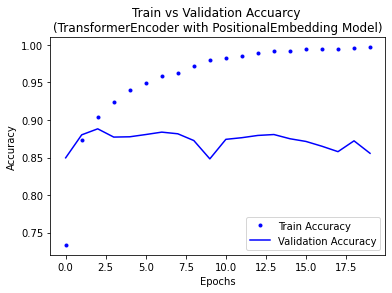

In [53]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(train_acc,"b.",label="Train Accuracy")
plt.plot(val_acc,"b-",label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuarcy \n(TransformerEncoder with PositionalEmbedding Model)")
plt.legend()
plt.show()

In [54]:
model = keras.models.load_model("transformer_encoder_positional_embeddings.keras",
                                custom_objects={"TransformerEncoder": TransformerEncoder,"PositionalEmbedding": PositionalEmbedding})
loss, acc = model.evaluate(test_ds_int)
print(f"Accuracy: {acc:.3f}")

782/782 [==============================] - 23s 29ms/step - loss: 0.2943 - accuracy: 0.8816
Accuracy: 0.882


# Conclusion
The Binary Bigram Dense model outperforms the other models with %89.3 accuracy